# Building an NLP Model for Medical Abstracts

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

## Reference Paper
We are replicating the approach from the following paper, which is also the source of the dataset used in this notebook:  
[https://arxiv.org/abs/1710.06071](https://arxiv.org/abs/1710.06071)

## Model Architecture
The model architecture that achieves the best results, as described in the reference paper, can be found here:  
[https://arxiv.org/abs/1612.05251](https://arxiv.org/abs/1612.05251)


## Confirm access to a GPU

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Get the Data
Since we will replicate the paper above (PubMud 200k RCT) lets download the dataset [https://github.com/Franck-Dernoncourt/pubmed-rct.git](https://github.com/Franck-Dernoncourt/pubmed-rct.git)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in PubMed_20k
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start our experement using the 20k dataset with numbers replaced by '@' sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check all file names in the target directory
import os
for filenames in os.listdir(data_dir):
  print(data_dir+'/'+filenames)

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//dev.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//train.txt


## data preprocessing
Now we've got some text data, it's time to become one with the data and one of the best ways to become one with the data is to Visualize

In [6]:
# Create a function that reads the lines of a document and returns them as a list
def read_lines(filename):
    """
    Reads a file and returns its lines as a list.

    Parameters:
        filename (str): The path to the file to be read.

    Returns:
        list: A list containing each line of the file as a string.
    """
    lines = []  # Initialize an empty list to store the lines
    with open(filename, 'r') as f:  # Open the file in read mode
        for line in f:  # Iterate over each line in the file
            lines.append(line)  # Append the line to the list
    return lines  # Return the list of lines


In [7]:
# lets read the training lines
train_lines = read_lines(data_dir+'/train.txt')
train_lines[0:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

# Lets think about how we want our data to look
How I think our data would be represented
```
[{'line_number':0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity ./n',
  'total_line':11},
  ....]
```

In [9]:
# Lets write a function wich turns each of our datasets into the above formate so we continue to prepare the data
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = read_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 913 ms, sys: 181 ms, total: 1.09 s
Wall time: 1.82 s


(180040, 30212, 30135)

In [11]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
# Distribution of labels
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

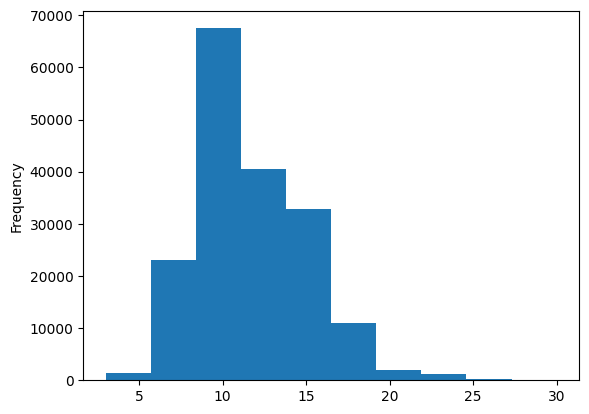

In [14]:
# Lets check the length of differant lines
train_df.total_lines.plot(kind='hist')

### Get list of Sentances

In [15]:
# Convert abstract text line into list
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

# Make numeric labels


In [16]:
# One hot encoding labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1,1))
train_labels_one_hot.shape, val_labels_one_hot.shape, test_labels_one_hot.shape

((180040, 5), (30212, 5), (30135, 5))

In [17]:
# Label Encoding labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels = label_encoder.transform(val_df.target.to_numpy())
test_labels = label_encoder.transform(test_df.target.to_numpy())

train_labels.shape, val_labels.shape, test_labels.shape

((180040,), (30212,), (30135,))

In [18]:
train_labels

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number from LabelEncoder
num_clases  = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names, num_clases

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

# Starting a Series of modeling expermints


# Model 0 Base_line

In [20]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Make predictions
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
from helper_functions import accuracy_score, precision_recall_fscore_support,calculate_results

model_0_pred_results = calculate_results(val_labels, model_0_preds)
model_0_pred_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 1 Convolution

In [23]:
# Preparing the data
import tensorflow as tf
from typing_extensions import Text
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
import numpy as np



In [24]:
# How long is each sentance
sent_long = [len(sent.split()) for sent in train_sentences]
avg_length = np.mean(sent_long)
avg_length

26.338269273494777

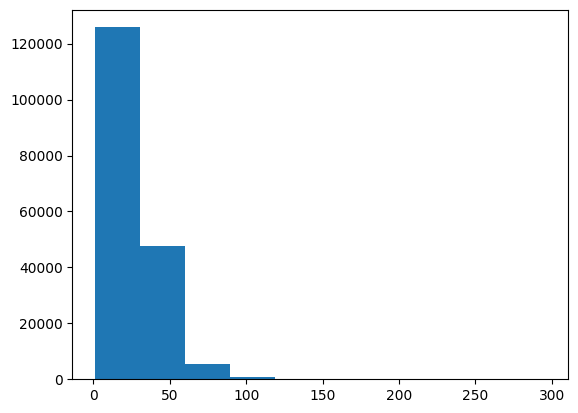

In [25]:
# Check the distrubution
import matplotlib.pyplot as plt
plt.hist(sent_long)
plt.show()

In [26]:
# How long sentance length cover 95% of examples
output_sent = int(np.quantile(sent_long, 0.95))
output_sent


55

In [27]:
# Max sent Lenght
max(sent_long)

296

In [28]:
# How many word in our vocab? Taken from papr two in our paper
max_vocab =  68000


In [29]:
# Preparing Text Vectorizer layer
text_vectorizer = TextVectorization(max_tokens=max_vocab,output_mode="int",output_sequence_length=output_sent)

# Adobt text vectorizer to training sentances
text_vectorizer.adapt(train_sentences)

In [30]:
# test out text vectorizer on random sentances
import random
random_target = random.choice(train_sentences)
print(f"Original text:\n{random_target}\n\nVectorized version:")
print(text_vectorizer([random_target]))


Original text:
instruction using both media improved wayfinding and navigation skills .

Vectorized version:
tf.Tensor(
[[ 3380    59    54  2666   170 21351     3  3974   719     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)


In [31]:
# How many words in our text vectorizer layer
words_in_vocab_pub_20k = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(words_in_vocab_pub_20k)}')
print(f'Most common words: {words_in_vocab_pub_20k[:5]}')
print(f'Least common words: {words_in_vocab_pub_20k[-5:]}')

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [32]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Creating custom text embedding


In [33]:
embedding = Embedding(
    input_dim=max_vocab,        # The size of the vocabulary (maximum number of unique tokens in your dataset)
    output_dim=128,             # The size of the dense vector for each word (embedding dimension)
    input_length=output_sent,   # The fixed length of input sequences (padding/truncation applied to match this length)
    mask_zero=True              # Masks the padding token (index 0) to prevent it from contributing to the model's learning
)

In [34]:
# Show an example of embedding
print(f'Original text:\n{random_target}\n\nEmbedded version:')
print(embedding(text_vectorizer([random_target])))
print(f'Embedded version shape: {embedding(text_vectorizer([random_target])).shape}')

Original text:
instruction using both media improved wayfinding and navigation skills .

Embedded version:
tf.Tensor(
[[[ 0.01855041  0.04275023 -0.02120267 ...  0.01083332 -0.01556512
   -0.00032517]
  [-0.0230721   0.01542271  0.01550526 ...  0.03093315  0.01261553
    0.04600746]
  [-0.01330724 -0.01663169  0.01099211 ...  0.01964724 -0.01784708
    0.04955466]
  ...
  [-0.03216966 -0.02510254 -0.00596377 ... -0.00978053  0.03695554
    0.01856849]
  [-0.03216966 -0.02510254 -0.00596377 ... -0.00978053  0.03695554
    0.01856849]
  [-0.03216966 -0.02510254 -0.00596377 ... -0.00978053  0.03695554
    0.01856849]]], shape=(1, 55, 128), dtype=float32)
Embedded version shape: (1, 55, 128)


## Creating datasets (making sure our data load afsp) using tensorflow.data api

In [35]:
# turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset, val_dataset, test_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [36]:
# Take tensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset, val_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [37]:
# Building Model 1 using a convolutional neural network (CNN) for text classification

# Input layer: Accepts raw text input
input = layers.Input(shape=(1,), dtype=tf.string, name='input_layer')  # Input shape is a single string (text input)

# Text preprocessing: Convert input text into tokenized sequences
x = text_vectorizer(input)  # Apply text vectorization to convert text to numerical token sequences

# Embedding layer: Convert token sequences to dense word embeddings
x = embedding(x)  # Embedding layer maps token indices to dense vectors of a fixed size

# Convolutional layer: Extract local features from the word embeddings
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
# - `filters=64`: The number of convolutional filters (feature maps)
# - `kernel_size=5`: Size of the convolutional window (captures 5-gram features)
# - `activation='relu'`: ReLU activation for non-linearity

# Global pooling: Reduce the dimensionality of feature maps
x = layers.GlobalMaxPool1D()(x)
# - Global max pooling selects the maximum value across each feature map, summarizing the most important features

# Dense layer: Fully connected layer for further feature extraction
x = layers.Dense(64, activation='relu')(x)
# - `64`: Number of neurons in the dense layer
# - `activation='relu'`: ReLU activation for non-linearity

# Output layer: Produces the final classification output
output = layers.Dense(num_clases, activation='softmax')(x)
# - `num_clases`: Number of classes for classification
# - `activation='softmax'`: Converts the output to probabilities for each class

# Create the model: Specify the input and output layers
model_1 = tf.keras.Model(inputs=input, outputs=output)
# - `inputs=input`: Defines the input layer
# - `outputs=output`: Defines the output layer
model_1.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160  

In [39]:
# Fit the model to the training data and validate on the validation dataset
model_1_history = model_1.fit(
    train_dataset,                  # The training dataset (preprocessed input and labels)
    steps_per_epoch=int(0.1 * len(train_dataset)),  # Number of steps per epoch (10% of the total training dataset)
    epochs=3,                       # Number of complete passes through the training dataset
    validation_data=val_dataset     # The validation dataset for monitoring performance during training
)

# Explanation:
# - `train_dataset`: Contains the input data and corresponding labels for training the model.
# - `steps_per_epoch`: Controls how many batches are processed in one epoch. Here, it processes 10% of the training dataset.
# - `epochs=3`: The model will train for 3 full passes through the dataset.
# - `validation_data`: The validation dataset is used to evaluate the model's performance after each epoch to detect overfitting or underfitting.


Epoch 1/3
562/562 [==============================] - 135s 238ms/step - loss: 0.8383 - accuracy: 0.6714 - val_loss: 0.5989 - val_accuracy: 0.7778
Epoch 2/3
562/562 [==============================] - 127s 226ms/step - loss: 0.5891 - accuracy: 0.7811 - val_loss: 0.5624 - val_accuracy: 0.7882
Epoch 3/3
562/562 [==============================] - 130s 231ms/step - loss: 0.5523 - accuracy: 0.7954 - val_loss: 0.5237 - val_accuracy: 0.8062


In [40]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5237 - accuracy: 0.8062


[0.5237446427345276, 0.8062028288841248]

In [41]:
# Make some preditions
model_1_preds = model_1.predict(val_dataset)
model_1_preds

945/945 [==============================] - 7s 7ms/step


array([[5.9466547e-01, 5.2848462e-02, 1.5326330e-03, 3.4838149e-01,
        2.5720263e-03],
       [9.7493730e-02, 8.3952528e-01, 1.0341859e-03, 5.5843964e-02,
        6.1027533e-03],
       [1.6894493e-01, 2.0092663e-03, 1.0628476e-03, 8.2788193e-01,
        1.0108597e-04],
       ...,
       [3.5011786e-04, 2.3375140e-03, 9.3332846e-03, 2.3735783e-04,
        9.8774171e-01],
       [5.2807711e-02, 6.1913335e-01, 3.3837754e-02, 4.1087568e-02,
        2.5313371e-01],
       [5.4303650e-03, 9.8545164e-01, 1.9437132e-03, 7.6957908e-04,
        6.4046509e-03]], dtype=float32)

In [42]:
# COnvert prediction to classes
model_1_preds = tf.argmax(model_1_preds, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [43]:
# Calculate model 1 results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 80.62028333112671,
 'precision': 0.8042204047717288,
 'recall': 0.8062028333112671,
 'f1': 0.8050798849688862}

# model 2: Feature extraction using pretrained token embedding


In [44]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [45]:
# Test on random sample
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")
tf_hub_embedding_layer([random_sentence])
#

Original text:
discomfort visual analog scores were @ and @ in the @ fr and @ fr groups , respectively ( p = @ ) on procedure day ; on the following day , the scores were @ and @ ( p = @ ) .

Embedded version:


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-3.67252380e-02, -7.21088573e-02,  5.09955622e-02,
         3.47685628e-03,  3.74453142e-02, -1.91956926e-02,
        -1.50054591e-02,  1.01037435e-02, -6.61587492e-02,
         5.68313114e-02, -8.24502960e-04, -2.82913935e-03,
         2.60421429e-02,  3.81166302e-02,  2.64899004e-02,
         3.02740522e-02, -2.96251066e-02,  3.53967063e-02,
         6.15607277e-02,  3.67068052e-02,  8.54729936e-02,
        -3.74495536e-02, -5.20512015e-02, -2.60089301e-02,
         2.09999606e-02,  1.55591955e-02, -4.95212302e-02,
         6.32530153e-02,  2.45789345e-03, -4.18504281e-03,
         7.45990947e-02,  7.05398843e-02,  5.33699691e-02,
        -3.43080647e-02, -6.49564713e-02,  4.09646444e-02,
         1.30647551e-02, -7.47976750e-02,  7.55046234e-02,
        -2.91041452e-02, -3.76356058e-02,  5.51533289e-02,
        -6.40447438e-02, -1.41337877e-02,  4.98357927e-03,
         6.83590025e-02,  4.88801524e-02, -5.19036688e-02,
      

## BUilding and fitting an NLP feature extraction model using tensorflow hub pretrained model


In [46]:
!pip install tensorflow==2.12.0
!pip install tensorflow-hub==0.13.0

In [47]:
# define feature extraction model using tf hub layer
model_2_input = layers.Input(shape=[], dtype=tf.string, name='input_layer')
model_2_embedding = tf_hub_embedding_layer(model_2_input)
model_2_output = layers.Dense(num_clases, activation='softmax')(model_2_embedding)
model_2 = tf.keras.Model(inputs=model_2_input, outputs=model_2_output,name='use_feature_extractor')
model_2.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [48]:
model_2.summary()

Model: "use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=3,
    validation_data=val_dataset
)

Epoch 1/3
562/562 [==============================] - 42s 65ms/step - loss: 1.2619 - accuracy: 0.5373 - val_loss: 1.0853 - val_accuracy: 0.6000
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 1.0134 - accuracy: 0.6252 - val_loss: 0.9543 - val_accuracy: 0.6519
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.9322 - accuracy: 0.6554 - val_loss: 0.8944 - val_accuracy: 0.6737


In [50]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 22s 24ms/step - loss: 0.8944 - accuracy: 0.6737


[0.8943997025489807, 0.6737058162689209]

In [51]:
model_2_preds = model_2.predict(val_dataset)
model_2_preds

945/945 [==============================] - 13s 13ms/step


array([[0.35821494, 0.33012268, 0.05136725, 0.16893259, 0.0913626 ],
       [0.3054229 , 0.45860767, 0.04137274, 0.1242368 , 0.07035985],
       [0.18423714, 0.2893321 , 0.12505198, 0.25355715, 0.1478216 ],
       ...,
       [0.0161943 , 0.01690043, 0.19062982, 0.01281814, 0.7634573 ],
       [0.03367913, 0.08104438, 0.37097833, 0.01881201, 0.49548614],
       [0.24219194, 0.11352306, 0.42510253, 0.03579447, 0.18338804]],
      dtype=float32)

In [52]:
model_2_preds = tf.argmax(model_2_preds, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 1, ..., 4, 4, 2])>

In [53]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 67.37058122600291,
 'precision': 0.6693714838552649,
 'recall': 0.6737058122600291,
 'f1': 0.6580683099374592}

# Model 3: Conv1d with character embedding


### Create character level tokenizer

In [54]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [55]:
# make function to split sentences into characters
def split_sentences(sentence):
  return " ".join(list(sentence))

In [56]:
split_sentences(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [57]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_sentences(sentence) for sentence in train_sentences]
val_chars = [split_sentences(sentence) for sentence in val_sentences]
test_chars = [split_sentences(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [58]:
# Whats the average character length
char_lengths = [len(char_list) for char_list in train_chars]
avg_length = np.mean(char_lengths)
avg_length

297.7325149966674

In [59]:
# what the max character length
max_char_length = max(char_lengths)
max_char_length

2771

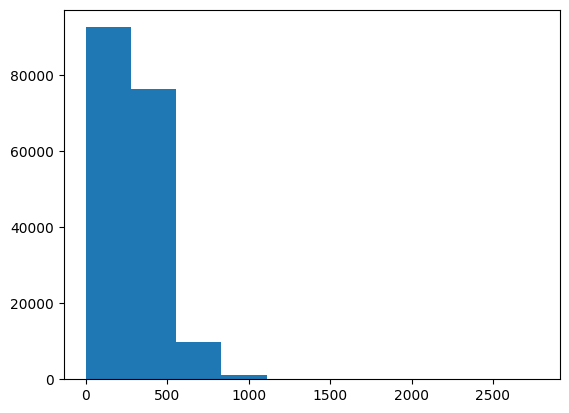

In [60]:
# check the distribution
plt.hist(char_lengths)
plt.show()

In [61]:
# find what character length covered in 95% percentile
output_char_length = int(np.quantile(char_lengths, 0.95))
output_char_length


579

In [62]:
# get all keyboad charaters
import string
alphapet = string.ascii_lowercase + string.digits + string.punctuation
alphapet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Create char level token vectorizer

In [63]:

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphapet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_char_length,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [64]:
# Chack character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of characters in vocab: {len(char_vocab)}')
print(f'5 characters in vocab: {char_vocab[:5]}')
print(f'Most common characters: {char_vocab[-5:]}')

Number of characters in vocab: 28
5 characters in vocab: ['', '[UNK]', 'e', 't', 'i']
Most common characters: ['k', 'x', 'z', 'q', 'j']


In [65]:
# test out vectorizer
print(f'Original text:\n{random_target}\n\nVectorized version:')
print(char_vectorizer([random_target]))

Original text:
instruction using both media improved wayfinding and navigation skills .

Vectorized version:
tf.Tensor(
[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [66]:
# Create the embedding layer
char_embedding = Embedding(
    input_dim=NUM_CHAR_TOKENS,
    output_dim=25,
    mask_zero=True,
    name='char_embedding'
)

## Create the embeddings layer

In [67]:
# test the embedding layer
print(f'Original text:\n{random_target}\n\nEmbedded version:')
print(char_embedding(char_vectorizer([random_target])))
print(f'Embedded version shape: {char_embedding(char_vectorizer([random_target])).shape}')

Original text:
instruction using both media improved wayfinding and navigation skills .

Embedded version:
tf.Tensor(
[[[ 0.04679189  0.04153142  0.04348227 ... -0.03422763  0.02595044
    0.00632792]
  [ 0.04679189  0.04153142  0.04348227 ... -0.03422763  0.02595044
    0.00632792]
  [ 0.04679189  0.04153142  0.04348227 ... -0.03422763  0.02595044
    0.00632792]
  ...
  [ 0.00312511 -0.03348722  0.04453466 ... -0.00683684  0.03173684
    0.01619356]
  [ 0.00312511 -0.03348722  0.04453466 ... -0.00683684  0.03173684
    0.01619356]
  [ 0.00312511 -0.03348722  0.04453466 ... -0.00683684  0.03173684
    0.01619356]]], shape=(1, 579, 25), dtype=float32)
Embedded version shape: (1, 579, 25)


## Building the model

In [68]:
inputs = layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_clases, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='char_cnn')
model_3.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
model_3.summary()

Model: "char_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 579)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 579, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 575, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                416

In [69]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [70]:
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset
)
#

Epoch 1/3
562/562 [==============================] - 49s 86ms/step - loss: 1.2340 - accuracy: 0.4904 - val_loss: 1.0248 - val_accuracy: 0.5858
Epoch 2/3
562/562 [==============================] - 41s 73ms/step - loss: 0.9697 - accuracy: 0.6115 - val_loss: 0.9136 - val_accuracy: 0.6405
Epoch 3/3
562/562 [==============================] - 38s 68ms/step - loss: 0.9007 - accuracy: 0.6404 - val_loss: 0.8562 - val_accuracy: 0.6602


In [71]:
model_3.evaluate(val_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 1.5077 - accuracy: 0.4040


[1.50770902633667, 0.40401163697242737]

In [72]:
model_3_preds = model_3.predict(val_dataset)
model_3_preds

945/945 [==============================] - 13s 14ms/step


array([[0.17895785, 0.0631531 , 0.3787278 , 0.05498738, 0.32417384],
       [0.3035921 , 0.07660604, 0.34548217, 0.06225377, 0.21206596],
       [0.189639  , 0.06015356, 0.43465483, 0.06148031, 0.25407222],
       ...,
       [0.31418943, 0.07996605, 0.2245884 , 0.06985134, 0.3114047 ],
       [0.16478013, 0.05570662, 0.4236112 , 0.05372759, 0.30217445],
       [0.30359206, 0.07660603, 0.3454822 , 0.06225376, 0.2120659 ]],
      dtype=float32)

In [73]:
model_3_preds = tf.argmax(model_3_preds, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 0, 2, 2])>

In [74]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results
#

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 40.40116509996028,
 'precision': 0.3559600888178865,
 'recall': 0.4040116509996028,
 'f1': 0.3297981832112441}

# Model 4:
Steps to Build the Model

1. **Create a Token-Level Model**  
   - Build a model similar to `model_1` that processes token-level sequences.

2. **Create a Character-Level Model**  
   - Construct a model similar to `model_3` with a slight modification to reflect the paper.

3. **Combine Outputs**  
   - Use `layers.Concatenate` to merge the outputs of the token-level and character-level models.

4. **Build Output Layers**  
   - Add a series of layers on top of the concatenated output, following the structure in **Figure 1** and **Section 4.2** of *[Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)*.

5. **Construct the Final Model**  
   - Create a model that takes token and character-level sequences as input and produces sequence label probabilities as output.


In [75]:
# 1. Setup token inputs and model
# Create the input layer for token-level sequences
token_inputs = layers.Input(shape=[], dtype=tf.string, name='input_layer')
# Pass token inputs through a pre-trained embedding layer from TensorFlow Hub
token_embeddings = tf_hub_embedding_layer(token_inputs)
# Add a dense layer to process token embeddings
token_output = layers.Dense(128, activation='relu')(token_embeddings)
# Define the token-level model
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output, name='token_model')

# 2. Setup character inputs and model
# Create the input layer for character-level sequences
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input_layer')
# Vectorize the character inputs using a pre-defined character vectorizer
char_vectorizer_layer = char_vectorizer(char_inputs)
# Pass the vectorized characters through an embedding layer
char_embedding_layer = char_embedding(char_vectorizer_layer)
# Use a bidirectional LSTM layer to extract sequential features from character embeddings
# This layer reflects the bi-LSTM mentioned in Figure 1 of the paper
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding_layer)
# Define the character-level model
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm, name='char_model')

# 3. Concatenate token and character inputs
# Combine the outputs of the token-level and character-level models
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layers with dropout for regularization
# Apply dropout to the concatenated features to prevent overfitting
combined_dropout = layers.Dropout(0.5)(token_char_concat)
# Add a dense layer to process combined features
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
# Apply another dropout layer
final_dropout = layers.Dropout(0.5)(combined_dense)
# Add the final output layer with softmax activation for classification
final_output = layers.Dense(num_clases, activation='softmax')(final_dropout)

# 5. Create the final model
# Combine the token and character input layers and define the model
model_4 = tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=final_output,
    name='model_4_token_char_embeddings'
)


In [76]:
# Get a summary
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 input_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 579)         0           ['char_input_layer[0][0]']       
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['inp

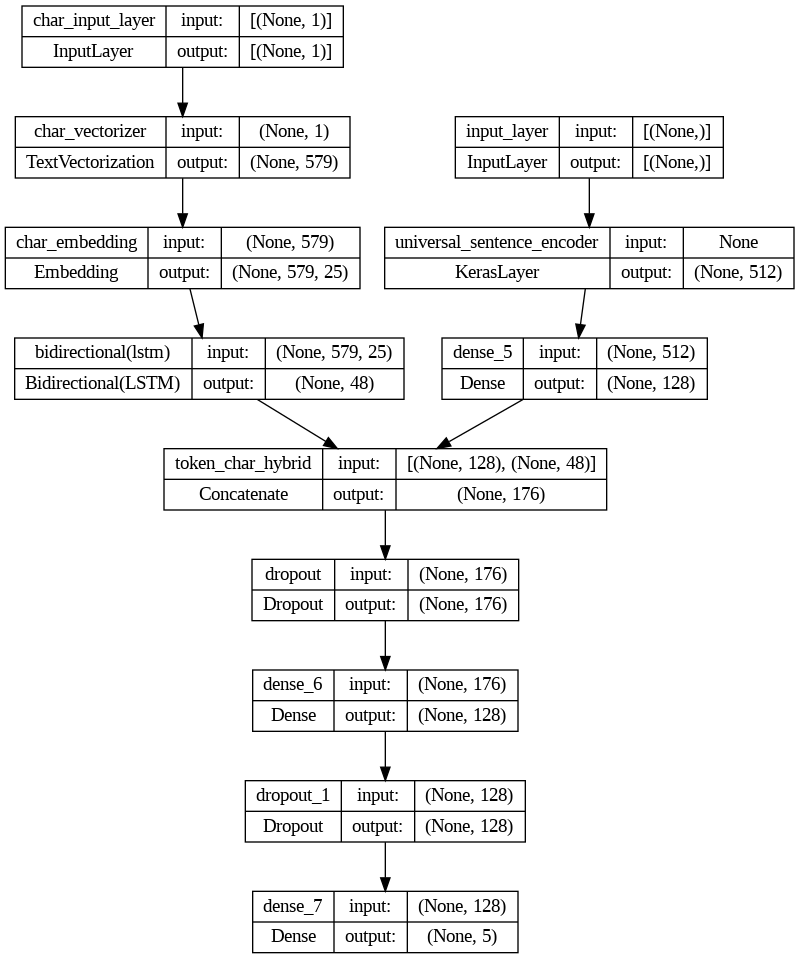

In [77]:
# plot the hyprid model
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)


In [78]:
# Compile the model
model_4.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [79]:
# combien char and token into one dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset_combined = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels))

# Prefetch
train_dataset_combined = train_dataset_combined.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat the same steps for validation
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset_combined = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels))

# Prefetch
val_dataset_combined = val_dataset_combined.batch(32).prefetch(tf.data.AUTOTUNE)


In [80]:
# Check out our training char and token embedding dataset
train_dataset_combined,val_dataset_combined

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [81]:
# Fitting
model_4_history = model_4.fit(
    train_dataset_combined,
    steps_per_epoch=int(0.1 * len(train_dataset_combined)),
    epochs=3,
    validation_data=val_dataset_combined
)

Epoch 1/3
562/562 [==============================] - 585s 1s/step - loss: 0.9820 - accuracy: 0.6094 - val_loss: 0.7911 - val_accuracy: 0.6952
Epoch 2/3
562/562 [==============================] - 594s 1s/step - loss: 0.8016 - accuracy: 0.6907 - val_loss: 0.7261 - val_accuracy: 0.7232
Epoch 3/3
562/562 [==============================] - 582s 1s/step - loss: 0.7738 - accuracy: 0.7053 - val_loss: 0.6989 - val_accuracy: 0.7335


In [82]:
model_4.evaluate(val_dataset_combined)

945/945 [==============================] - 139s 147ms/step - loss: 0.6989 - accuracy: 0.7335


[0.6989437341690063, 0.7335164546966553]

In [83]:
model_4_preds = model_4.predict(val_dataset_combined)
model_4_preds

945/945 [==============================] - 207s 215ms/step


array([[4.3670556e-01, 3.5334244e-01, 5.7024076e-03, 1.9599164e-01,
        8.2579171e-03],
       [4.1802973e-01, 4.0588120e-01, 4.7409511e-03, 1.6930595e-01,
        2.0420349e-03],
       [3.1490296e-01, 1.2465434e-01, 4.5133203e-02, 4.8206761e-01,
        3.3241875e-02],
       ...,
       [6.4644864e-04, 1.2830653e-02, 6.4529240e-02, 3.0302021e-04,
        9.2169064e-01],
       [5.7891784e-03, 4.9758859e-02, 2.3227845e-01, 2.6600813e-03,
        7.0951337e-01],
       [3.3906832e-01, 3.6134416e-01, 2.2605410e-01, 4.0824629e-02,
        3.2708816e-02]], dtype=float32)

In [84]:
model_4_preds = tf.argmax(model_4_preds, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [85]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 73.35164835164835,
 'precision': 0.734183525305087,
 'recall': 0.7335164835164835,
 'f1': 0.7314037904669825}

## Create positional embeddings

In [86]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


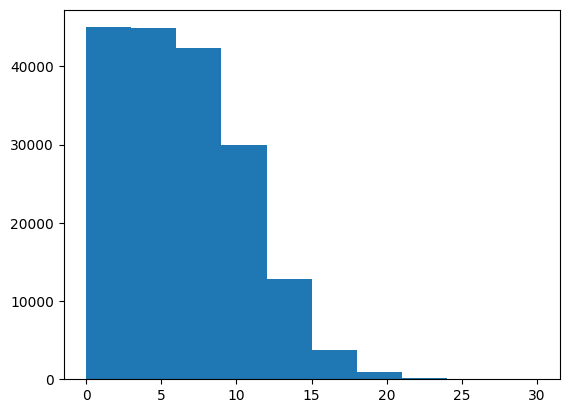

In [87]:
# Check the distribution
plt.hist(train_df['line_number'])
plt.show()

In [88]:
# Use tensorflow to create one hot encoding tensors of our line_number column
train_lines_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_lines_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
train_lines_numbers_one_hot , train_lines_numbers_one_hot.shape


(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoding our lines numbers lets do the same for lines feature

In [89]:
# How many numbers of lines are there
train_df['total_lines'].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


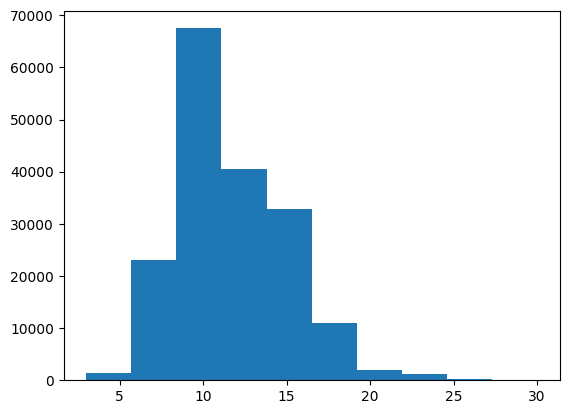

In [90]:
# Check distributuion for total_lines
plt.hist(train_df['total_lines'])
plt.show()

In [91]:
# Check the covrage of a total_lines value of 20
np.percentile(train_df['total_lines'],98)


20.0

In [92]:
# Use tensorflow to do one hot encoding tensors of our total_lines features
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
train_total_lines_one_hot , train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

# Building a tribid embedding model 5

1. Create a token-level model
2. create a character-level model
3. create a model for line number
4. create a model for total_lines
5. combine the outputs of 1 & 2 using tf.keras.concatenate
6. combine the outputs of 3 & 4 & 5 using tf.keras.concatenate
7. create an output layer to accept the tribried embedding and output labels probapilities
8. combine the inputs of 1,2,3,4 and the output of into tf.keras.model

In [93]:
train_lines_numbers_one_hot.shape, train_total_lines_one_hot.shape

(TensorShape([180040, 15]), TensorShape([180040, 20]))

In [94]:
train_lines_numbers_one_hot.dtype, train_total_lines_one_hot.dtype

(tf.float32, tf.float32)

In [104]:
# 1. Create the token-level model
# Input layer for token-based data (e.g., words or phrases as strings)
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input_layer')
# Pass token inputs through a pre-trained embedding layer from TensorFlow Hub
embedding_layer = tf_hub_embedding_layer(token_inputs)
# Create the token-level model
token_model = tf.keras.Model(inputs=token_inputs, outputs=embedding_layer, name='token_model')

# 2. Create the character-level model
# Input layer for character-based data (e.g., single characters)
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input_layer')
# Vectorize the character inputs into numerical form
char_vectorizer_layer = char_vectorizer(char_inputs)
# Embed the character vectors
char_embedding_layer = char_embedding(char_vectorizer_layer)
# Apply a Bidirectional LSTM layer for sequence modeling
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name='char_bi_lstm_layer')(char_embedding_layer)
# Create the character-level model
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm, name='char_model')

# 3. Create the line number model
# Input layer for line number data (e.g., normalized line indices in a document)
line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
# Dense layer to process line number inputs
line_number_output = layers.Dense(15, activation='relu', name='line_number_dense_layer')(line_number_input)
# Create the line number model
line_number_model = tf.keras.Model(inputs=line_number_input, outputs=line_number_output, name='line_number_model')

# 4. Create the total lines model
# Input layer for total lines data (e.g., normalized total line count in a document)
total_lines_input = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# Dense layer to process total lines inputs
total_lines_output = layers.Dense(32, activation='relu', name='total_lines_dense_layer')(total_lines_input)
# Create the total lines model
total_lines_model = tf.keras.Model(inputs=total_lines_input, outputs=total_lines_output, name='total_lines_model')

# 5. Combine token and character models
# Concatenate the outputs of the token and character-level models
token_char_concat = layers.Concatenate(name='token_char_hybrid_layer')([token_model.output, char_model.output])
# Dense layer to process combined token-character embeddings
x = layers.Dense(256, activation='relu', name='dense_combined_token_char')(token_char_concat)
# Dropout layer to prevent overfitting
dropout_layer = layers.Dropout(0.5, name='dropout_layer')(x)

# 6. Combine all embeddings
# Concatenate the outputs of the line number, total lines, and token-character hybrid embeddings
tribrid_embedding = layers.Concatenate(name='tribrid_embedding_layer')([line_number_model.output, total_lines_model.output, dropout_layer])

# 7. Create the output layer
# Output layer with a softmax activation for multi-class classification
output_layer = layers.Dense(num_clases, activation='softmax', name='output_layer')(tribrid_embedding)

# 8. Create the final tribrid model
# Combine all inputs and the output layer into a single Keras model
model_5 = tf.keras.Model(
    inputs=[token_model.input, char_model.input, line_number_model.input, total_lines_model.input],
    outputs=output_layer,
    name='model_5_tribrid'  # Name for the final model
)


In [105]:
# get summary for tribrid hypried model
model_5.summary()

Model: "model_5_tribrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 579)         0           ['char_input_layer[0][0]']       
 tion)                                                                                            
                                                                                                  
 token_input_layer (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, 579, 25)      1750        ['char_vectorizer[5

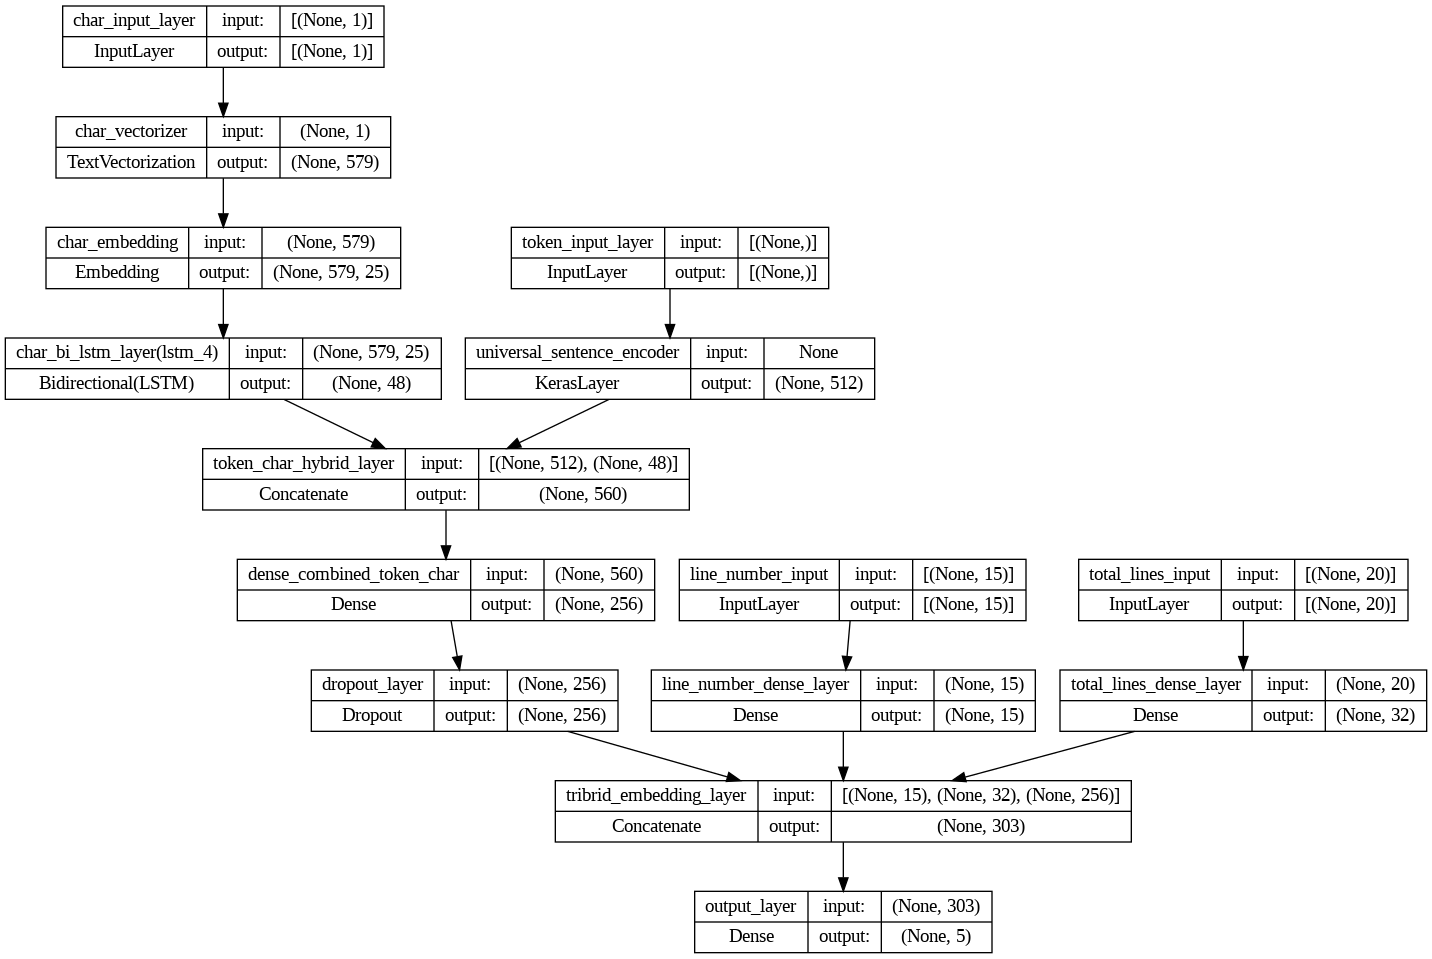

In [106]:
# plot the tribrid model
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True)


In [107]:
# Compile the model with the following configurations:
# - Loss: CategoricalCrossentropy with label smoothing set to 0.2, which helps reduce overconfidence by softening the one-hot encoded labels.
# - Optimizer: Adam optimizer, known for its adaptability and efficiency in training deep learning models.
# - Metrics: Track 'accuracy' during training and evaluation to monitor the performance of the model.
model_5.compile(
    loss=losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [110]:
# Create the tribrid dataset for training
# - Step 1: Combine all input features (token-level sentences, character-level sentences,
#           one-hot encoded line numbers, and one-hot encoded total lines) into a tf.data.Dataset.
train_tribrid_data = tf.data.Dataset.from_tensor_slices((
    train_sentences,  # Token-level sentence inputs
    train_chars,      # Character-level sentence inputs
    train_lines_numbers_one_hot,  # One-hot encoded line numbers
    train_total_lines_one_hot     # One-hot encoded total lines
))

# - Step 2: Create a tf.data.Dataset for the corresponding one-hot encoded labels.
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

# - Step 3: Zip the input features dataset and the labels dataset together.
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

# - Step 4: Batch the dataset with a batch size of 32 and use prefetching to optimize data loading.
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Create the tribrid dataset for validation (similar steps as training data)
# - Combine validation features into a tf.data.Dataset.
val_tribrid_data = tf.data.Dataset.from_tensor_slices((
    val_sentences,  # Token-level sentence inputs
    val_chars,      # Character-level sentence inputs
    val_lines_numbers_one_hot,  # One-hot encoded line numbers
    val_total_lines_one_hot     # One-hot encoded total lines
))

# - Create a tf.data.Dataset for the corresponding validation labels.
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

# - Zip the validation features dataset and the labels dataset together.
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

# - Batch the validation dataset and enable prefetching for optimization.
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [111]:
# Chek input shapes
train_tribrid_dataset,val_tribrid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fit model 5 to the data

In [112]:
# fit
model_5_history = model_5.fit(
    train_tribrid_dataset,
    steps_per_epoch=int(0.1 * len(train_tribrid_dataset)),
    epochs=3,
    validation_data=val_tribrid_dataset
)

Epoch 1/3
562/562 [==============================] - 595s 1s/step - loss: 1.1329 - accuracy: 0.7038 - val_loss: 1.0159 - val_accuracy: 0.7826
Epoch 2/3
562/562 [==============================] - 578s 1s/step - loss: 0.9894 - accuracy: 0.8045 - val_loss: 0.9693 - val_accuracy: 0.8137
Epoch 3/3
562/562 [==============================] - 563s 1s/step - loss: 0.9680 - accuracy: 0.8151 - val_loss: 0.9524 - val_accuracy: 0.8264


In [113]:
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 172s 182ms/step - loss: 0.9524 - accuracy: 0.8264


[0.9523976445198059, 0.8263934850692749]

In [114]:
model_5_pred = model_5.predict(val_tribrid_dataset)
model_5_pred

945/945 [==============================] - 172s 177ms/step


array([[0.53154063, 0.10860974, 0.01268396, 0.32340297, 0.02376272],
       [0.56000155, 0.10671785, 0.03291172, 0.2912161 , 0.00915282],
       [0.28942397, 0.14343055, 0.10720347, 0.39537063, 0.06457128],
       ...,
       [0.03403063, 0.12007011, 0.04245291, 0.02694584, 0.7765005 ],
       [0.02929389, 0.302326  , 0.08926666, 0.02460221, 0.5545112 ],
       [0.13881102, 0.55957305, 0.17434779, 0.03757245, 0.08969571]],
      dtype=float32)

In [115]:
model_5_pred = tf.argmax(model_5_pred, axis=1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [116]:
model_5_results = calculate_results(val_labels, model_5_pred)
model_5_results

{'accuracy': 82.63934860320403,
 'precision': 0.8247754791228208,
 'recall': 0.8263934860320402,
 'f1': 0.8251589989152435}

# Comparing the 5 models

In [123]:
# Combine model results in one dataframe
all_models_results = pd.DataFrame({'base_model':model_0_pred_results,
                                   'custom_token_embed_conv1d':model_1_results,
                                   'pretrained_token_embed':model_2_results,
                                   'custom_char_embed_conv1d':model_3_results,
                                   'hybrid_char_token_embed':model_4_results,
                                   'tribrid_pos_char_token_embed':model_5_results})
all_models_results = all_models_results.transpose()
# Reduce the accurcy to same scale as other metrics
all_models_results['accuracy'] = all_models_results['accuracy'] / 100

all_models_results

,accuracy,precision,recall,f1
base_model,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.806203,0.804220,0.806203,0.805080
pretrained_token_embed,0.673706,0.669371,0.673706,0.658068
custom_char_embed_conv1d,0.404012,0.355960,0.404012,0.329798
hybrid_char_token_embed,0.733516,0.734184,0.733516,0.731404
tribrid_pos_char_token_embed,0.826393,0.824775,0.826393,0.825159


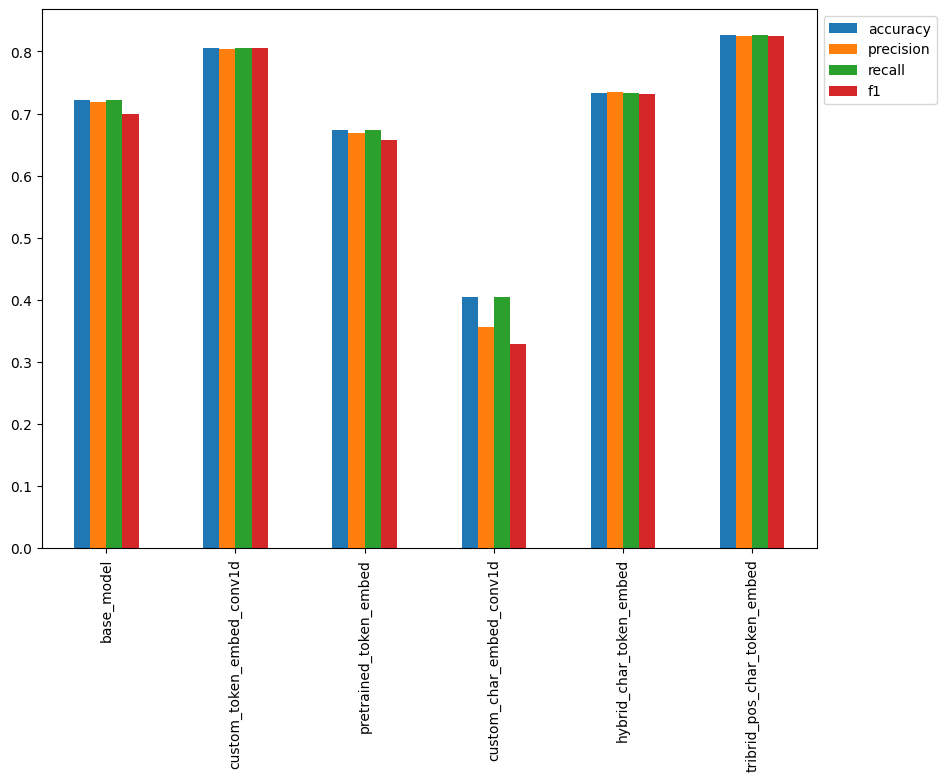

In [126]:
# Plot all models
all_models_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


<Axes: >

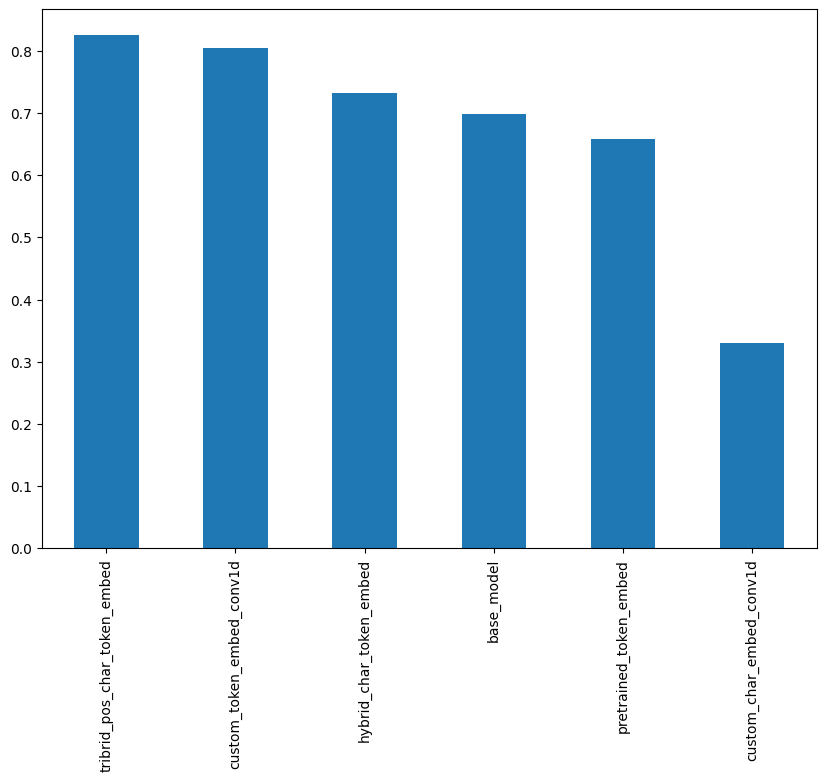

In [130]:
# Sort the models by F1-Score
all_models_results.sort_values('f1',ascending=False)['f1'].plot(kind='bar',figsize=(10,7))

# Save and load Model 5

In [131]:
# Save model 5
model_5.save('model_5_tribrid')

In [132]:
#load our model
model_5 = tf.keras.models.load_model('model_5_tribrid')

# Final Test

In [133]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-11-21 16:58:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-11-21 16:58:18 (48.8 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [134]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [163]:
def perepare_data_for_prediction(example_abstracts):
  from spacy.lang.en import English
  nlp = English() # setup English sentence parser

  # New version of spaCy
  sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

  # Old version of spaCy
  # sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
  # nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

  # Create "doc" of parsed sequences, change index for a different abstract
  doc = nlp(example_abstracts[0]["abstract"])
  abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Go through each line in abstract and create a list of dictionaries containing features for each line
  sample_lines = []
  for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)
  # Get all line_number values from sample abstract
  test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
  # Get all total_lines values from sample abstract
  test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
  # Split abstract lines into characters
  abstract_chars = [split_sentences(sentence) for sentence in abstract_lines]
  # Make predictions on sample abstract features
  test_abstract_pred_probs = model_5.predict(x=(
      tf.constant(abstract_lines),
      tf.constant(abstract_chars),
      test_abstract_line_numbers_one_hot,
      test_abstract_total_lines_one_hot
  ))
  test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
  test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

  # Visualize abstract lines and predicted sequence labels
  for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")


In [164]:
perepare_data_for_prediction(example_abstracts)

1/1 [==============================] - 0s 113ms/step
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored